In [ ]:
%reload_ext autoreload

In [ ]:
%autoreload 2

In [ ]:
import numpy as np # scientific computing
import pandas as pd # data loading and processing
import os # os operations
import matplotlib.pyplot as plt # for generating figures
import math
import matplotlib.dates as mdates
import seaborn as sns # for generating visualizations, better support with pandas than matplotlib
from scipy import stats
from sklearn.impute import SimpleImputer

from analysis_publication import *

In [ ]:
# script to consolidate all HCCDB data into one dataframe

hccdb_names = ["1", "3", "4",  "8", "9", "11", "12", "13", "14", "16", "17", "18"]
hccdb = pd.DataFrame()

for i in range(len(hccdb_names)):
    n1, n2 = construct_hccdb_filename(hccdb_names[i])
    hccdb_temp = get_hccdb_data(n1)
    hccdb_temp = hccdb_temp.loc[~hccdb_temp.index.duplicated(),:].copy()
    hccdb_temp.loc["ptype",:] = "HCCDB-" + hccdb_names[i]
    hccdb = pd.concat([hccdb, hccdb_temp], axis = 1) # patients x genes

# load pancan data

tcga = pd.read_csv("./data/EB++AdjustPANCAN_IlluminaHiSeq_RNASeqV2.geneExp (1).xena", index_col = 0, sep = "\t") # gene x patient
pheno = pd.read_csv("./data/TCGA_phenotype_denseDataOnlyDownload (1).tsv", index_col = 0, sep = "\t") # patient x phenotype

# attach cancer type to each patient
data = tcga.T
data = pd.concat([data, pheno], axis = 1, join = "inner") # patients x genes
    
print(data.shape)
print(tcga.T.shape)

# attach abbeviations for each cancer type
ls = data["_primary_disease"].unique().tolist()

conditions = [
    data['_primary_disease'] == 'adrenocortical cancer',
    data['_primary_disease'] == 'bladder urothelial carcinoma',
    data['_primary_disease'] == 'breast invasive carcinoma',
    data['_primary_disease'] == 'cervical & endocervical cancer',
    data['_primary_disease'] == 'cholangiocarcinoma', 
    data['_primary_disease'] == 'colon adenocarcinoma',
    data['_primary_disease'] == 'diffuse large B-cell lymphoma',
    data['_primary_disease'] == 'esophageal carcinoma',
    data['_primary_disease'] == 'glioblastoma multiforme',
    data['_primary_disease'] == 'head & neck squamous cell carcinoma',
    data['_primary_disease'] == 'kidney chromophobe',
    data['_primary_disease'] == 'kidney clear cell carcinoma',
    data['_primary_disease'] == 'kidney papillary cell carcinoma',
    data['_primary_disease'] == 'acute myeloid leukemia',
    data['_primary_disease'] == 'brain lower grade glioma',
    data['_primary_disease'] == 'liver hepatocellular carcinoma',
    data['_primary_disease'] == 'lung adenocarcinoma',
    data['_primary_disease'] == 'lung squamous cell carcinoma',
    data['_primary_disease'] == 'mesothelioma',
    data['_primary_disease'] == 'ovarian serous cystadenocarcinoma',
    data['_primary_disease'] == 'pancreatic adenocarcinoma',
    data['_primary_disease'] == 'pheochromocytoma & paraganglioma',
    data['_primary_disease'] == 'prostate adenocarcinoma',
    data['_primary_disease'] == 'rectum adenocarcinoma',
    data['_primary_disease'] == 'sarcoma',
    data['_primary_disease'] == 'skin cutaneous melanoma',
    data['_primary_disease'] == 'stomach adenocarcinoma',
    data['_primary_disease'] == 'testicular germ cell tumor',
    data['_primary_disease'] == 'thyroid carcinoma',
    data['_primary_disease'] == 'thymoma',
    data['_primary_disease'] == 'uterine corpus endometrioid carcinoma',
    data['_primary_disease'] == 'uterine carcinosarcoma',
    data['_primary_disease'] == 'uveal melanoma'    
]

choices = ["ACC",
           "BLCA",
           "BRCA",
           "CESC",
           "CHOL",
           "COAD",
           "DBLC",
           "ESCA",
           "GBM",
           "HNSC",
           "KICH",
           "KIRC",
           "KIRP",
           "LAML",
           "LGG",
           "LIHC",
           "LUAD",
           "LUSC",
           "MESO",
           "OV",
           "PAAD",
           "PCPG",
           "PRAD",
           "READ",
           "SARC",
           "SKCM",
           "STAD",
           "TGCT",
           "THCA",
           "THYM",
           "UCEC",
           "UCS",
           "UVM"
           ]

data["ptype"] = np.select(conditions, choices, default = "null")
data.head()


In [ ]:
analyses = ["RRM2B - NRF2 sig",
            "RRM2B - AOS sig",
            "RRM2B - G6PD",
            "RRM2B - p53 sig",
            "p53 sig - G6PD",
            ]

In [ ]:
aos_set = ['STAD', 'HNSC', 'SARC', 'UCS', 
           'LUSC', 'BRCA','Aggregated']
liver_set = ['LIHC','HCCDB-1', 'HCCDB-3', 'HCCDB-4','HCCDB-9','HCCDB-13','HCCDB-14', 'HCCDB-16', 'HCCDB-17']
p53_set = ['STAD', 'HNSC', 'LUSC']

In [ ]:
# master script to screen (publication) cancers for RRM2B - AOS

# load gene names
gene_set = pd.read_csv("./data/oxstress genes.csv", index_col=None, header= 0)
gene_set = gene_set['AOS_final'].dropna().tolist()
targets = list(set(["G6PD", "RRM2B"] +  gene_set))

# load database names
databases = aos_set

# define subplot grid
fig, axs = plt.subplots(2, 4, figsize=(28, 14), sharey=True)
plt.subplots_adjust(hspace=0.6)
title = 'RRM2B vs antioxidant signature'
fig.suptitle(title,fontsize = 25)

# main loop
for db, ax in zip(databases, axs.ravel()):
    print(db)
    df = get_data(data, hccdb, db)
    data_new = process_data(df, targets, x_var_names = ["RRM2B"], y_var_names = gene_set, pheno_filtered=None, outlier_corrected = True)
    analyse(data_new, fig, db, ax, title + ' screen (publication).png', x_label = "RRM2B", y_label = "Antioxidant signature")
    axs[1][3].set_visible(False)
print("done")


In [ ]:
# master script to screen cancers for RRM2B - NRF2 signature

gene_set = pd.read_csv("./data/oxstress genes.csv", index_col=None, header= 0)
gene_set = gene_set['NRF2_final'].dropna().tolist()

targets = list(set(["G6PD", "RRM2B"] +  gene_set))

databases = aos_set

# define subplot grid
fig, axs = plt.subplots(2, 4, figsize=(28, 14), sharey=True)
plt.subplots_adjust(hspace=0.5)
title = 'RRM2B vs NRF2 signature'
fig.suptitle(title,fontsize = 25)

for db, ax in zip(databases, axs.ravel()):
    print(db)
    df = get_data(data, hccdb, db)
    data_new = process_data(df, targets, x_var_names = ["RRM2B"], y_var_names = gene_set, pheno_filtered=None, outlier_corrected = True)
    analyse(data_new, fig, db, ax, title + ' screen (publication).png', x_label = "RRM2B", y_label = "NRF2 signature")
    axs[1][3].set_visible(False)
print("done")


In [ ]:
# # master script to screen cancers for RRM2B - p53 signature

# gene_set = pd.read_csv("./data/oxstress genes.csv", index_col=None, header= 0)
# gene_set = gene_set['p53 new'].dropna().tolist()

# targets = list(set(["G6PD", "RRM2B"] +  gene_set))

# databases = ['PANCAN'] # , , 'PANCAN'

# # define subplot grid
# fig, axs = plt.subplots(6, 8, figsize=(60, 40), sharey=True)
# plt.subplots_adjust(hspace=0.6)
# title = 'RRM2B vs p53 signature'
# fig.suptitle(title,fontsize = 25)

# for db, ax in zip(databases, axs.ravel()):
#     print(db)
#     df = get_data(data, hccdb, db)
#     data_new = process_data(df, targets, x_var_names = ["RRM2B"], y_var_names = gene_set, pheno_filtered=None, outlier_corrected = True)
#     analyse(data_new, fig, db, ax, title + ' screen (publication).png', x_label = "RRM2B", y_label = "p53 signature")
# print("done")


STAD
[]
[]


/Users/shanghongsim/Documents/GitHub/HU-ATRi-Code-Repository/analysis_publication.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_var_gene_set["x_composite_score"] = x_var_gene_set.mean(axis = 1)
/Users/shanghongsim/Documents/GitHub/HU-ATRi-Code-Repository/analysis_publication.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_var_gene_set["y_composite_score"]= y_var_gene_set.mean(axis = 1)


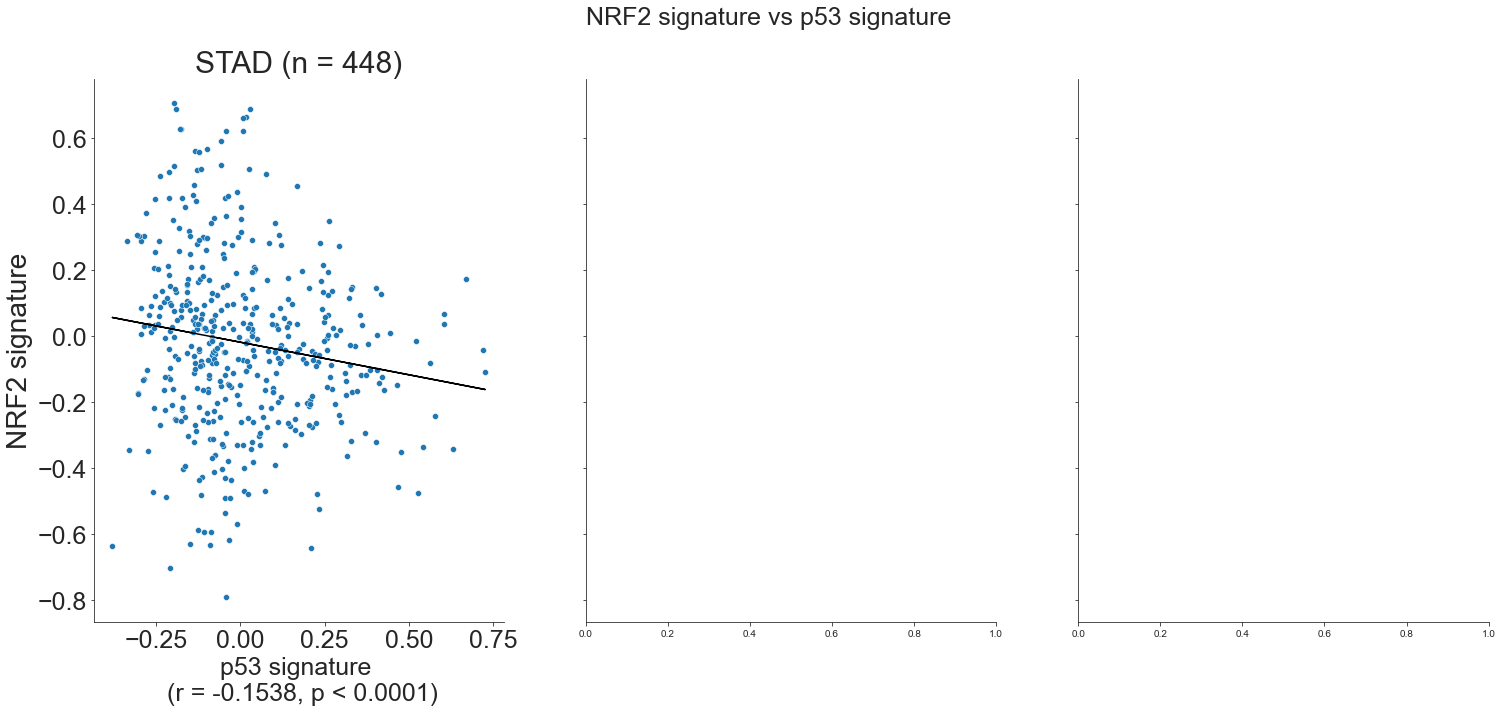

HNSC
[]
[]


/Users/shanghongsim/Documents/GitHub/HU-ATRi-Code-Repository/analysis_publication.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_var_gene_set["x_composite_score"] = x_var_gene_set.mean(axis = 1)
/Users/shanghongsim/Documents/GitHub/HU-ATRi-Code-Repository/analysis_publication.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_var_gene_set["y_composite_score"]= y_var_gene_set.mean(axis = 1)


<Figure size 432x288 with 0 Axes>

LUSC
[]
[]


/Users/shanghongsim/Documents/GitHub/HU-ATRi-Code-Repository/analysis_publication.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_var_gene_set["x_composite_score"] = x_var_gene_set.mean(axis = 1)
/Users/shanghongsim/Documents/GitHub/HU-ATRi-Code-Repository/analysis_publication.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_var_gene_set["y_composite_score"]= y_var_gene_set.mean(axis = 1)


<Figure size 432x288 with 0 Axes>

done


In [29]:
# master script to screen cancers for NRF2 signature - p53 signature

gene_set = pd.read_csv("./data/oxstress genes.csv", index_col=None, header= 0)
x_set = gene_set['p53 new'].dropna().tolist()
y_set = gene_set['NRF2_final'].dropna().tolist()

targets = list(set(["G6PD", "RRM2B"] +  x_set + y_set))

databases = p53_set

# define subplot grid
fig, axs = plt.subplots(1, 3, figsize=(25, 10), sharey=True)
plt.subplots_adjust(hspace=0.6)
title = 'NRF2 signature vs p53 signature'
fig.suptitle(title,fontsize = 25)

for db, ax in zip(databases, axs.ravel()):
    print(db)
    df = get_data(data, hccdb, db)
    data_new = process_data(df, targets, x_var_names = x_set, y_var_names = y_set, pheno_filtered=None, outlier_corrected = True)
    analyse(data_new, fig, db, ax, title + ' screen (publication).png', x_label = "p53 signature", y_label = "NRF2 signature")
print("done")


STAD
[]
[]


/Users/shanghongsim/Documents/GitHub/HU-ATRi-Code-Repository/analysis_publication.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_var_gene_set["x_composite_score"] = x_var_gene_set.mean(axis = 1)
/Users/shanghongsim/Documents/GitHub/HU-ATRi-Code-Repository/analysis_publication.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_var_gene_set["y_composite_score"]= y_var_gene_set.mean(axis = 1)


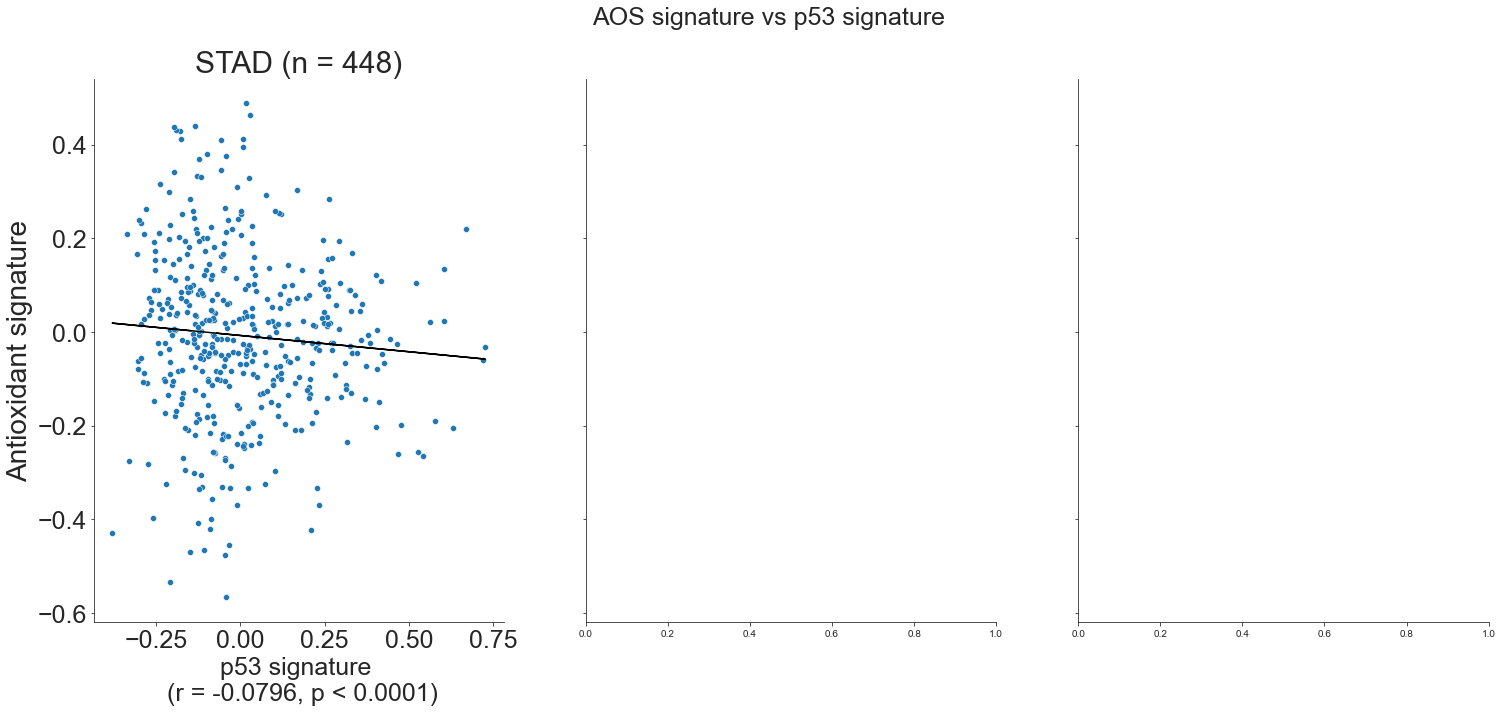

HNSC
[]
[]


/Users/shanghongsim/Documents/GitHub/HU-ATRi-Code-Repository/analysis_publication.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_var_gene_set["x_composite_score"] = x_var_gene_set.mean(axis = 1)
/Users/shanghongsim/Documents/GitHub/HU-ATRi-Code-Repository/analysis_publication.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_var_gene_set["y_composite_score"]= y_var_gene_set.mean(axis = 1)


<Figure size 432x288 with 0 Axes>

LUSC
[]
[]


/Users/shanghongsim/Documents/GitHub/HU-ATRi-Code-Repository/analysis_publication.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_var_gene_set["x_composite_score"] = x_var_gene_set.mean(axis = 1)
/Users/shanghongsim/Documents/GitHub/HU-ATRi-Code-Repository/analysis_publication.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_var_gene_set["y_composite_score"]= y_var_gene_set.mean(axis = 1)


<Figure size 432x288 with 0 Axes>

done


In [30]:
# master script to screen cancers for AOS signature - p53 signature

gene_set = pd.read_csv("./data/oxstress genes.csv", index_col=None, header= 0)
set_x = gene_set['p53 new'].dropna().tolist()
set_y = gene_set['AOS_final'].dropna().tolist()

targets = list(set(["G6PD", "RRM2B"] +  set_x + set_y))

databases = p53_set

# define subplot grid
fig, axs = plt.subplots(1, 3, figsize=(25, 10), sharey=True)
plt.subplots_adjust(hspace=0.6)
title = 'AOS signature vs p53 signature'
fig.suptitle(title,fontsize = 25)

for db, ax in zip(databases, axs.ravel()):
    print(db)
    df = get_data(data, hccdb, db)
    data_new = process_data(df, targets,  set_x, y_var_names = set_y, pheno_filtered=None, outlier_corrected = True)
    analyse(data_new, fig, db, ax, title + ' screen (publication).png', x_label = "p53 signature", y_label = "Antioxidant signature")
print("done")


In [ ]:
# master script to screen cancers for p53 signature vs G6PD

gene_set = pd.read_csv("./data/oxstress genes.csv", index_col=None, header= 0)
x_set = gene_set['p53 new'].dropna().tolist()
y_set = gene_set['NRF2_final'].dropna().tolist()

targets = list(set(["G6PD", "RRM2B"] +  x_set + y_set))

databases = liver_set 

# define subplot grid
fig, axs = plt.subplots(2, 5, figsize=(28, 10), sharey=True)
plt.subplots_adjust(hspace=0.6)
title = 'p53 signature vs G6PD'
fig.suptitle(title,fontsize = 25)

for db, ax in zip(databases, axs.ravel()):
    print(db)
    df = get_data(data, hccdb, db)
    data_new = process_data(df, targets, x_var_names = x_set, y_var_names = ["G6PD"], pheno_filtered=None, outlier_corrected = True)
    analyse(data_new, fig, db, ax, title + ' screen liver (publication).png', x_label = "p53 signature", y_label = "G6PD")
    axs[1][4].set_visible(False)
print("done")


In [ ]:
# master script to screen cancers for p53 signature vs G6PD

gene_set = pd.read_csv("./data/oxstress genes.csv", index_col=None, header= 0)
x_set = gene_set['p53 new'].dropna().tolist()
y_set = gene_set['NRF2_final'].dropna().tolist()

targets = list(set(["G6PD", "RRM2B"] +  x_set + y_set))

databases = aos_set 

# define subplot grid
fig, axs = plt.subplots(2, 4, figsize=(28, 14), sharey=True)
plt.subplots_adjust(hspace=0.6)
title = 'p53 signature vs G6PD'
fig.suptitle(title,fontsize = 25)

for db, ax in zip(databases, axs.ravel()):
    print(db)
    df = get_data(data, hccdb, db)
    data_new = process_data(df, targets, x_var_names = x_set, y_var_names = ["G6PD"], pheno_filtered=None, outlier_corrected = True)
    analyse(data_new, fig, db, ax, title + ' screen (publication).png', x_label = "p53 signature", y_label = "G6PD")
    axs[1][3].set_visible(False)
print("done")


In [ ]:
# master script to screen cancers for RRM2B vs G6PD

targets = ["G6PD", "RRM2B"]

databases = aos_set

# define subplot grid
fig, axs = plt.subplots(2, 4, figsize=(28, 14), sharey=True)
plt.subplots_adjust(hspace=0.6)
title = 'RRM2B vs G6PD'
fig.suptitle(title,fontsize = 25)

for db, ax in zip(databases, axs.ravel()):
    print(db)
    df = get_data(data, hccdb, db)
    data_new = process_data(df, targets,x_var_names = ["RRM2B"], y_var_names = ["G6PD"], pheno_filtered=None, outlier_corrected = True)
    analyse(data_new, fig, db, ax, title + ' screen (publication).png', x_label = "RRM2B", y_label = "G6PD")
    axs[1][3].set_visible(False)
print("done")


In [ ]:
# # master script to screen cancers for RRM2B vs NRF2 signature

# gene_set = pd.read_csv("./data/oxstress genes.csv", index_col=None, header= 0)
# gene_set = gene_set['NRF2_final'].dropna().tolist()

# targets = list(set(["G6PD", "RRM2B"] +  gene_set))

# databases = ['PANCAN', 'COAD'] # , , 'PANCAN'

# # define subplot grid
# fig, axs = plt.subplots(6, 8, figsize=(60, 40), sharey=True)
# plt.subplots_adjust(hspace=0.6)
# title = 'RRM2B vs NRF2 signature'
# fig.suptitle(title,fontsize = 40)

# print("run")
# for db, ax in zip(databases, axs.ravel()):
#     df = get_data(data, hccdb, db)
#     data_new = process_data(df, targets, x_var_names = ["RRM2B"], y_var_names = gene_set, pheno_filtered=None, outlier_corrected = True)
#     analyse(data_new, fig,db, ax, title + ' screen (publication).png', x_label = "RRM2B", y_label = "NRF2 signature")
# print("done")




# # master script to screen cancers for RRM2B expression vs antioxidant activity

# gene_set = pd.read_csv("./data/oxstress genes.csv", index_col=None, header= 0)
# gene_set = gene_set['AOS_final'].dropna().tolist()

# targets = list(set(["G6PD", "RRM2B"] +  gene_set))

# databases = ['PANCAN', 'COAD'] # , , 'PANCAN'

# # define subplot grid
# fig, axs = plt.subplots(6, 8, figsize=(60, 40), sharey=True)
# plt.subplots_adjust(hspace=0.6)
# fig.suptitle('RRM2B vs antioxidant signature',fontsize = 40)

# print("run")
# for db, ax in zip(databases, axs.ravel()):
#     df = get_data(data, hccdb, db)
#     data_new = process_data(df, targets, x_var_names = ["RRM2B"], y_var_names = gene_set, pheno_filtered=None, outlier_corrected = True)
#     # data_new = data_new.loc[data_new["RRM2B"] > -0.4, :] 
#     analyse(data_new, fig, db, ax, title + ' screen (publication).png', x_label = "RRM2B expression", y_label = "Antioxidant signature", x_target = 'RRM2B', y_target = 'y_composite_score', )
# print("done")


In [ ]:
import missingno as msno  # # pip install missingno

# Plot correlation heatmap of missingness
msno.matrix(df)

# Plot correlation heatmap of missingness
msno.bar(df.T)

In [ ]:
df = data[data["ptype"] == 'LUSC']
df = df.T
df.drop(["ptype","sample_type_id", "sample_type", "_primary_disease"], inplace = True)	

# Plot correlation heatmap of missingness
msno.matrix(df)

In [ ]:
hccdb

In [ ]:
import missingno as msno  # # pip install missingno

df = hccdb.T
df = df[df["ptype"] == "HCCDB-1"]
df = df.T
df.drop(["ptype"], inplace = True)

# Plot correlation heatmap of missingness
msno.matrix(df)

In [ ]:
df

In [ ]:
gene_set = pd.read_csv("./data/oxstress genes.csv", index_col=None, header= 0)
gene_set = gene_set['AOS_final'].dropna().tolist()

targets = list(set(["G6PD", "RRM2B"] +  gene_set))

df.loc[targets]

In [ ]:
import missingno as msno  # # pip install missingno

df = hccdb.T
df = df[df["ptype"] == "HCCDB-3"]
df = df.T
df.drop(["ptype"], inplace = True)

# Plot correlation heatmap of missingness
msno.matrix(df)

In [ ]:
import missingno as msno  # # pip install missingno

df = hccdb.T
df = df[df["ptype"] == "HCCDB-4"]
df = df.T
df.drop(["ptype"], inplace = True)

# Plot correlation heatmap of missingness
msno.matrix(df)

In [ ]:
import missingno as msno  # # pip install missingno

df = hccdb.T
df = df[df["ptype"] == "HCCDB-18"]
df = df.T
df.drop(["ptype"], inplace = True)

# Plot correlation heatmap of missingness
msno.matrix(df)

# single gene screen

In [ ]:
def process_data_gene_comparisons(df, targets, y_var_names, pheno_filtered=None):

    # subset to get relevant genes
    df_filtered = df.loc[targets]
    # print(df_filtered)
    print(df_filtered.isnull().values.any())

    # check for nan values
    na_filter = df_filtered.isnull().any()
    na_ls = na_filter[na_filter == True].index.to_list()
    print(na_ls)
    
    # impute nan values
    mean_ls = df_filtered.mean()
    for na_col in na_ls:
        df_filtered[na_col] = df_filtered[na_col].fillna(mean_ls[na_col])
    
    # df_filtered = df
    print(df_filtered.isnull().values.any())
    
    df_filtered = df_filtered.T # patients x genes
    df_filtered = df_filtered.astype(np.float64)

    # scale numerical data
    df_filtered = np.log10(df_filtered+1)

    # for each sequenced gene were rescaled to set the median equal to 1
    df_filtered=(df_filtered-df_filtered.median())/(df_filtered.std()+1)

    data = df_filtered   

    # # take only nrf2 target genes
    # y_var_gene_set = data[y_var_names]
    # data.drop(y_var_names, inplace = True, axis = 1)
    # y_var_gene_set["composite_score"] = y_var_gene_set.mean(axis = 1)
    # data = pd.concat([data, y_var_gene_set], axis = 1) # patients x genes 
    
    return data


In [ ]:
# single gene screen

gene_set = pd.read_csv("./data/oxstress genes.csv", index_col=None, header= 0)
gene_set = gene_set['NRF2_final'].dropna().tolist()

targets = list(set(["G6PD", "RRM2B"] +  gene_set))

r_all =[]
p_all = []

databases = ['DBLC', 'SKCM', 'HNSC', 'PRAD', 'PAAD', 'SARC', 
             'BRCA', 'UCS', 'ESCA', 'STAD', 'LAML', 'OV' ] # , , 'PANCAN'

genes =['CAT', 'PRDX1', 'PRDX6', 'GPX2', 'GSR', 
        'SLC6A9', 'TXN', 'SRXN1', 'G6PD', 'IDH1', 
        'ME1', 'PGD', 'AKR1B10', 'AKR1C1', 'ALDH3A1', 
        'CBR1', 'EPHX1', 'NQO1', 'NQO2', 'PTGR1', 
        'UGT1A6', 'GSTA1', 'GSTA2', 'GSTA3', 'GSTA4', 
        'GSTA5', 'GSTM1', 'GSTM2', 'GSTM3', 'GSTP1' ]

for db in databases:

    # load data
    df = data[data["ptype"] == db]
    df = df.T # genes x patients
    df.drop(["ptype","sample_type_id", "sample_type", "_primary_disease"], inplace = True)

    # define subplot grid
    fig, axs = plt.subplots(5, 6, figsize=(50, 30))
    plt.subplots_adjust(hspace=0.6, wspace = 0.4)
    fig.suptitle('Single gene comparison ' + db + " (n = " + str(df.shape[1]) + ")",fontsize = 40)

    rtemp = [db]
    ptemp = [db]
    print(db)
    
    for g, ax in zip(genes, axs.ravel()):
        print(g)
        data_new = process_data_gene_comparisons(df, targets, gene_set, pheno_filtered=None)
        r,p=analyse(data_new, fig, "RRM2B vs " + g , ax, 'RRM2B vs genes' + db + '.png', x_label = "RRM2B", y_label = g, x_target = 'RRM2B', y_target = g )
        rtemp.append(r)
        ptemp.append(p)

    r_all.append(rtemp)
    p_all.append(ptemp)
    
print("done")

df_r = pd.DataFrame(r_all, columns = ["database"] + genes)
df_p = pd.DataFrame(p_all, columns = ["database"] + genes)
df_r.to_csv("r values.csv")
df_p.to_csv("p values.csv")


In [ ]:
# single gene screen
# RRM2B vs NRF2 genes

gene_set = pd.read_csv("./data/oxstress genes.csv", index_col=None, header= 0)
x_set = gene_set['p53 new'].dropna().tolist()
y_set = gene_set['NRF2_final'].dropna().tolist()

targets = list(set(["G6PD", "RRM2B"] +  x_set + y_set))

r_all =[]
p_all = []

databases = ['HNSC', 'SARC', 'LUSC', 'UCS', 'STAD', 'LAML', 'PRAD', 'PAAD', 'BRCA'] # , , 'PANCAN'


genes =['CAT', 'PRDX1', 'PRDX6', 'GPX2', 'GSR', 
        'SLC6A9', 'TXN', 'SRXN1', 'G6PD', 'IDH1', 
        'ME1', 'PGD', 'AKR1B10', 'AKR1C1', 'ALDH3A1', 
        'CBR1', 'EPHX1', 'NQO1', 'NQO2', 'PTGR1', 
        'UGT1A6', 'GSTA1', 'GSTA2', 'GSTA3', 'GSTA4', 
        'GSTA5', 'GSTM1', 'GSTM2', 'GSTM3', 'GSTP1' ]

for db in databases:
    
    # load data
    df = data[data["ptype"] == db]
    df = df.T # genes x patients
    df.drop(["ptype","sample_type_id", "sample_type", "_primary_disease"], inplace = True)

    # define subplot grid
    fig, axs = plt.subplots(5, 6, figsize=(50, 30))
    plt.subplots_adjust(hspace=0.6, wspace = 0.4)
    fig.suptitle('Single gene comparison ' + db + " (n = " + str(df.shape[1]) + ")",fontsize = 40)

    rtemp = [db]
    ptemp = [db]
    print(db)
    
    for g, ax in zip(genes, axs.ravel()):
        try:
            print(g)
            data_new = process_data(df, targets, x_var_names = ["RRM2B"], y_var_names = None, pheno_filtered=None)
            r,p=analyse(data_new, fig, "RRM2B vs " + g , ax, 'RRM2B-genes-selected' + db + '.png', x_label = "RRM2B", y_label = g, x_target = 'RRM2B', y_target = g )
            rtemp.append(r)
            ptemp.append(p)

        except KeyError:
            print("key error")
            continue

    r_all.append(rtemp)
    p_all.append(ptemp)
    
print("done")

df_r = pd.DataFrame(r_all, columns = ["database"] + genes)
df_p = pd.DataFrame(p_all, columns = ["database"] + genes)
df_r.to_csv("r values RRM2B-genes-selected.csv")
df_p.to_csv("p values RRM2B-genes-selected.csv")


In [ ]:
# single gene screen
# p53 sig vs NRF2 genes

gene_set = pd.read_csv("./data/oxstress genes.csv", index_col=None, header= 0)
x_set = gene_set['p53 new'].dropna().tolist()
y_set = gene_set['NRF2_final'].dropna().tolist()

targets = list(set(["G6PD", "RRM2B"] +  x_set + y_set))

r_all =[]
p_all = []

databases = ['HNSC', 'SARC', 'LUSC', 'UCS', 'STAD', 'LAML', 'PRAD', 'PAAD', 'BRCA'] # , , 'PANCAN'


genes =['CAT', 'PRDX1', 'PRDX6', 'GPX2', 'GSR', 
        'SLC6A9', 'TXN', 'SRXN1', 'G6PD', 'IDH1', 
        'ME1', 'PGD', 'AKR1B10', 'AKR1C1', 'ALDH3A1', 
        'CBR1', 'EPHX1', 'NQO1', 'NQO2', 'PTGR1', 
        'UGT1A6', 'GSTA1', 'GSTA2', 'GSTA3', 'GSTA4', 
        'GSTA5', 'GSTM1', 'GSTM2', 'GSTM3', 'GSTP1' ]

for db in databases:

    # load data
    df = data[data["ptype"] == db]
    df = df.T # genes x patients
    df.drop(["ptype","sample_type_id", "sample_type", "_primary_disease"], inplace = True)

    # define subplot grid
    fig, axs = plt.subplots(5, 6, figsize=(50, 30))
    plt.subplots_adjust(hspace=0.6, wspace = 0.4)
    fig.suptitle('Single gene comparison ' + db + " (n = " + str(df.shape[1]) + ")",fontsize = 40)

    rtemp = [db]
    ptemp = [db]
    print(db)
    
    for g, ax in zip(genes, axs.ravel()):
        try:
            print(g)
            data_new = process_data(df, targets, x_var_names = x_set, y_var_names = None, pheno_filtered=None)
            r,p=analyse(data_new, fig, "p53 sig vs " + g , ax, 'p53sig-genes-selected' + db + '.png', x_label = "p53 signature", y_label = g, x_target = 'x_composite_score', y_target = g )
            rtemp.append(r)
            ptemp.append(p)
        except KeyError:
            print("key error")
            continue

    r_all.append(rtemp)
    p_all.append(ptemp)
    
print("done")

df_r = pd.DataFrame(r_all, columns = ["database"] + genes)
df_p = pd.DataFrame(p_all, columns = ["database"] + genes)
df_r.to_csv("r values p53sig-genes-selected.csv")
df_p.to_csv("p values p53sig-genes-selected.csv")


In [ ]:
import missingno as msno  # # pip install missingno

# Plot correlation heatmap of missingness
msno.matrix(data)
